In [ ]:
!nvidia-smi

Thu Jul 22 13:15:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers


     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 40.2 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 3.3 MB 47.4 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.9.0



In [ ]:

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!unzip /content/drive/MyDrive/datasets.zip


Archive:  /content/drive/MyDrive/datasets.zip
   creating: datasets/
  inflating: datasets/classifiedExtremismAnsar.txt  
  inflating: datasets/classifiedExtremismTurnToIslam.txt  
  inflating: datasets/classifiedMovies.txt  
  inflating: datasets/classifiedSentiment140_Test.txt  
  inflating: datasets/classifiedSentiment140_Training.txt  
  inflating: datasets/classifiedT4SA.txt  
  inflating: datasets/._readme.txt   
  inflating: datasets/readme.txt     
  inflating: __MACOSX/datasets/._readme.txt  


In [ ]:
ls datasets/


classifiedExtremismAnsar.txt*        classifiedSentiment140_Training.txt*
classifiedExtremismTurnToIslam.txt*  classifiedT4SA.txt*
classifiedMovies.txt*                readme.txt*
classifiedSentiment140_Test.txt*


In [ ]:
df_t4sa = pd.read_csv('/content/datasets/classifiedT4SA.txt', sep="\t", header= None,  engine='python')

In [ ]:
df_t4sa.columns = ["id","message","scoreP","scoreN","polarity","originalClassification","termsP","termsN"]

In [ ]:
df = df_t4sa


In [ ]:
df = df.iloc[1: , :]

In [ ]:
import ast
df['message'] = df['message'].apply(ast.literal_eval).str.decode("utf-8")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import re
def clean_txt(text):
  #text=re.sub('(?:\s)b"RT[^, ]*', '', text) 
  text = re.sub(r"RT" , "",text)
  text = re.sub(r":" , "",text)
  #text = re.sub("\bb'\b" , "",text)
  #text=re.sub('(?:\s)@[^, ]*', "", text)
  text = re.sub('@[\w]+','',text) #for removing usernames @....
  
  return text

In [ ]:
"""import re
text = " b'RT @MBJCorbet: .@MayorMemphis makes good on b\"RT @MBJCorbet b'abc"
#re.sub('(?:\s)@[^, ]*', '', my_string)
#re.sub('(?:\s)b"RT @[^, ]*', '', a)
#re.sub('(?:\s)b'RT @[^, ]*', '', a)
#re.sub('(b"R\S+|\S*[^\w\s,]\S*)','',a)
#re.sub('(^|\s)(b\"RT\S+|[^\w\s",]\S*),'\\1',a)
#re.sub('(?:\s)@[^, ]*', "", text)

#re.sub('@[\w]+','',text)
#re.sub('b'[\w]+','',text)
re.sub('(?:\s)b"RT[^, ]*', '', text) """

'import re\ntext = " b\'RT @MBJCorbet: .@MayorMemphis makes good on b"RT @MBJCorbet b\'abc"\n#re.sub(\'(?:\\s)@[^, ]*\', \'\', my_string)\n#re.sub(\'(?:\\s)b"RT @[^, ]*\', \'\', a)\n#re.sub(\'(?:\\s)b\'RT @[^, ]*\', \'\', a)\n#re.sub(\'(b"R\\S+|\\S*[^\\w\\s,]\\S*)\',\'\',a)\n#re.sub(\'(^|\\s)(b"RT\\S+|[^\\w\\s",]\\S*),\'\\1\',a)\n#re.sub(\'(?:\\s)@[^, ]*\', "", text)\n\n#re.sub(\'@[\\w]+\',\'\',text)\n#re.sub(\'b\'[\\w]+\',\'\',text)\nre.sub(\'(?:\\s)b"RT[^, ]*\', \'\', text) '

In [ ]:

df['message']  = df.message.apply(clean_txt)
#df1.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
del df_t4sa

In [ ]:
df

,id,message,scoreP,scoreN,polarity,originalClassification,termsP,termsN
1,758014713804587008,And surprise! the #RegularShow #38 has a sho...,0,0,Inconclusive,Not Classified,NaN,NaN
2,758014717990428672,My unproblematic fav who knows Bellarke is f...,0,0,Inconclusive,Not Classified,NaN,NaN
3,758014646716665857,I mean we know harry isn't human https//t.co...,0,0,Inconclusive,Not Classified,NaN,NaN
4,758014655071526912,"She's ready, resilient, and on our latest co...",0,0,Inconclusive,Not Classified,NaN,NaN
5,758014642526429184,find someone who loves you as much as Pikach...,0,0,Inconclusive,Not Classified,NaN,NaN
...,...,...,...,...,...,...,...,...
3452659,804619269736726528,Kojima with the inspiration from the old Noriy...,0,0,Inconclusive,Not Classified,NaN,NaN
3452660,804619286488682496,Bixbeat Mixtape Vol.2 is here with great artis...,0,0,Inconclusive,Positive,NaN,NaN
3452661,804619303286964225,"#FreeWaqar Guys, Grab your keyboards and start...",0,0,Inconclusive,Not Classified,NaN,NaN
3452662,804619395561623552,To create a charisma and aura with their style...,0.93,0,Positive Extreme,Not Classified,beauty,NaN


In [ ]:
#df = df.drop(labels=0, axis=0)

In [ ]:
df = df.drop(["id",	"scoreP",	"scoreN",	"termsP",	"termsN"], axis=1)

In [ ]:
df['message'] = df['message'].astype(str)

In [ ]:
df.isna().sum()

message                   0
polarity                  0
originalClassification    0
dtype: int64

In [ ]:
df.polarity.value_counts()

Inconclusive        3134881
Positive Extreme     293568
Negative Extreme      24114
Extreme                 100
Name: polarity, dtype: int64

In [ ]:
df.drop(df.loc[df['polarity']=="Extreme"].index, inplace=True)

In [ ]:
df.originalClassification.value_counts()

Not Classified    2272646
Neutral            629562
Positive           371337
Negative           179018
Name: originalClassification, dtype: int64

In [ ]:
"""def to_sentiment(rating):
  rating = str(rating)
  if rating == "Inconclusive":
    return 0
  elif rating == "Positive Extreme":
    return 1
  elif rating == "Negative Extreme":
    return 2
  elif rating == "Positive Non-Extreme":
    return 3
  else:
    return 4
df['label'] = df.polarity.apply(to_sentiment)"""

'def to_sentiment(rating):\n  rating = str(rating)\n  if rating == "Inconclusive":\n    return 0\n  elif rating == "Positive Extreme":\n    return 1\n  elif rating == "Negative Extreme":\n    return 2\n  elif rating == "Positive Non-Extreme":\n    return 3\n  else:\n    return 4\ndf[\'label\'] = df.polarity.apply(to_sentiment)'

In [ ]:
df['label'] = pd.factorize(df['polarity'])[0]

In [ ]:
df.label.value_counts()

0    3134881
1     293568
2      24114
Name: label, dtype: int64

In [ ]:
class_names = ['Inconclusive', 'Positive Extreme', 'Negative Extreme']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


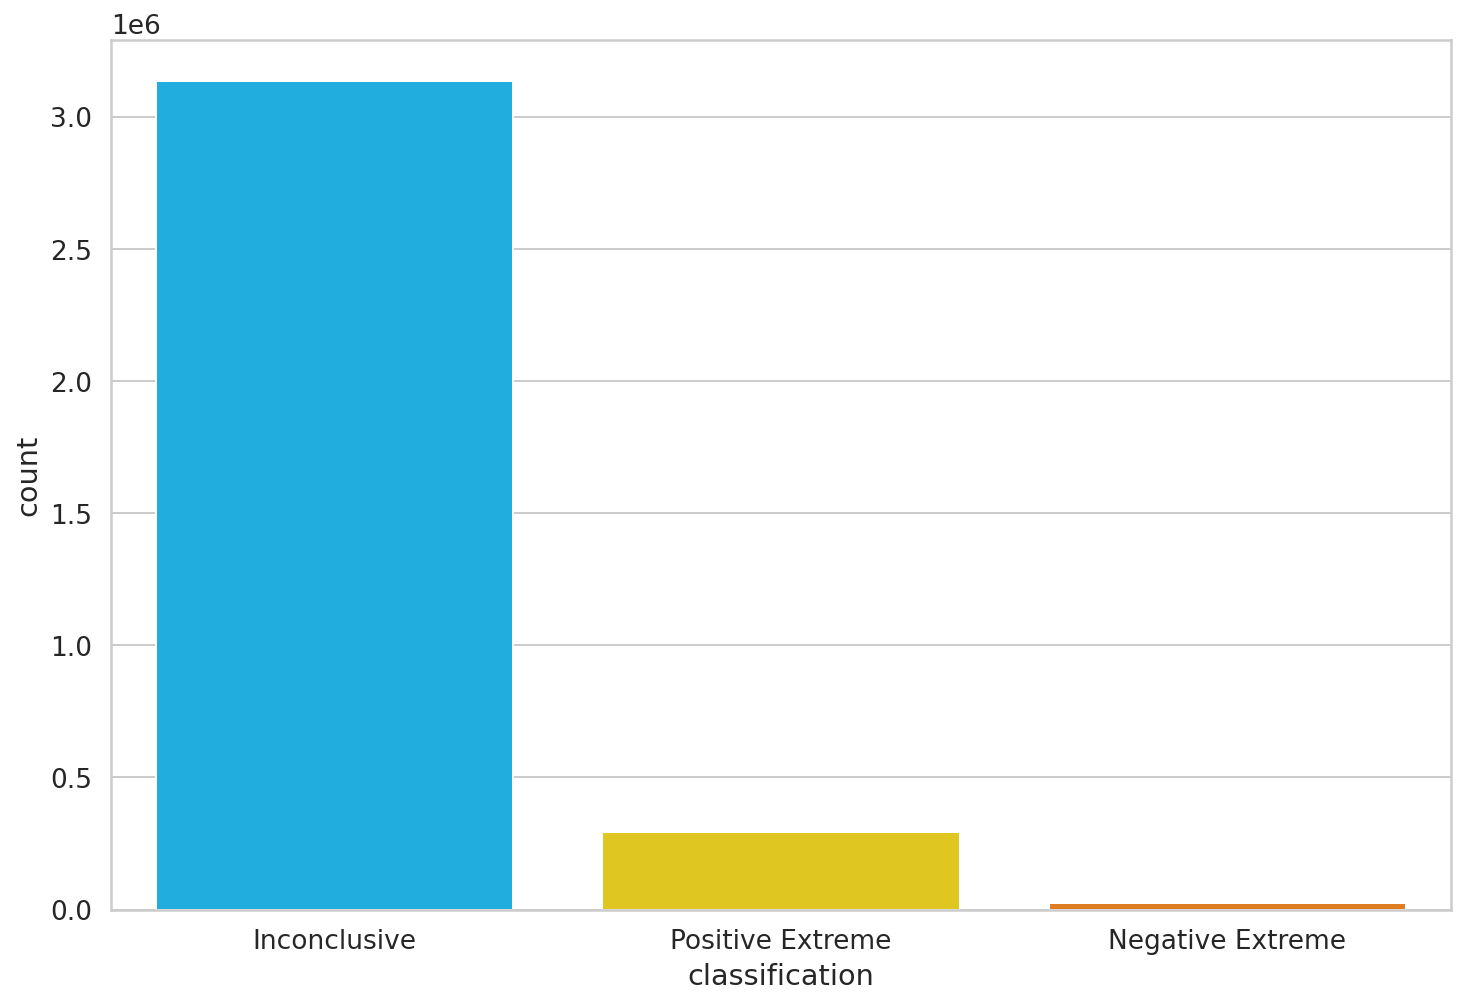

In [ ]:
sns.countplot(df.polarity)
plt.xlabel('classification');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


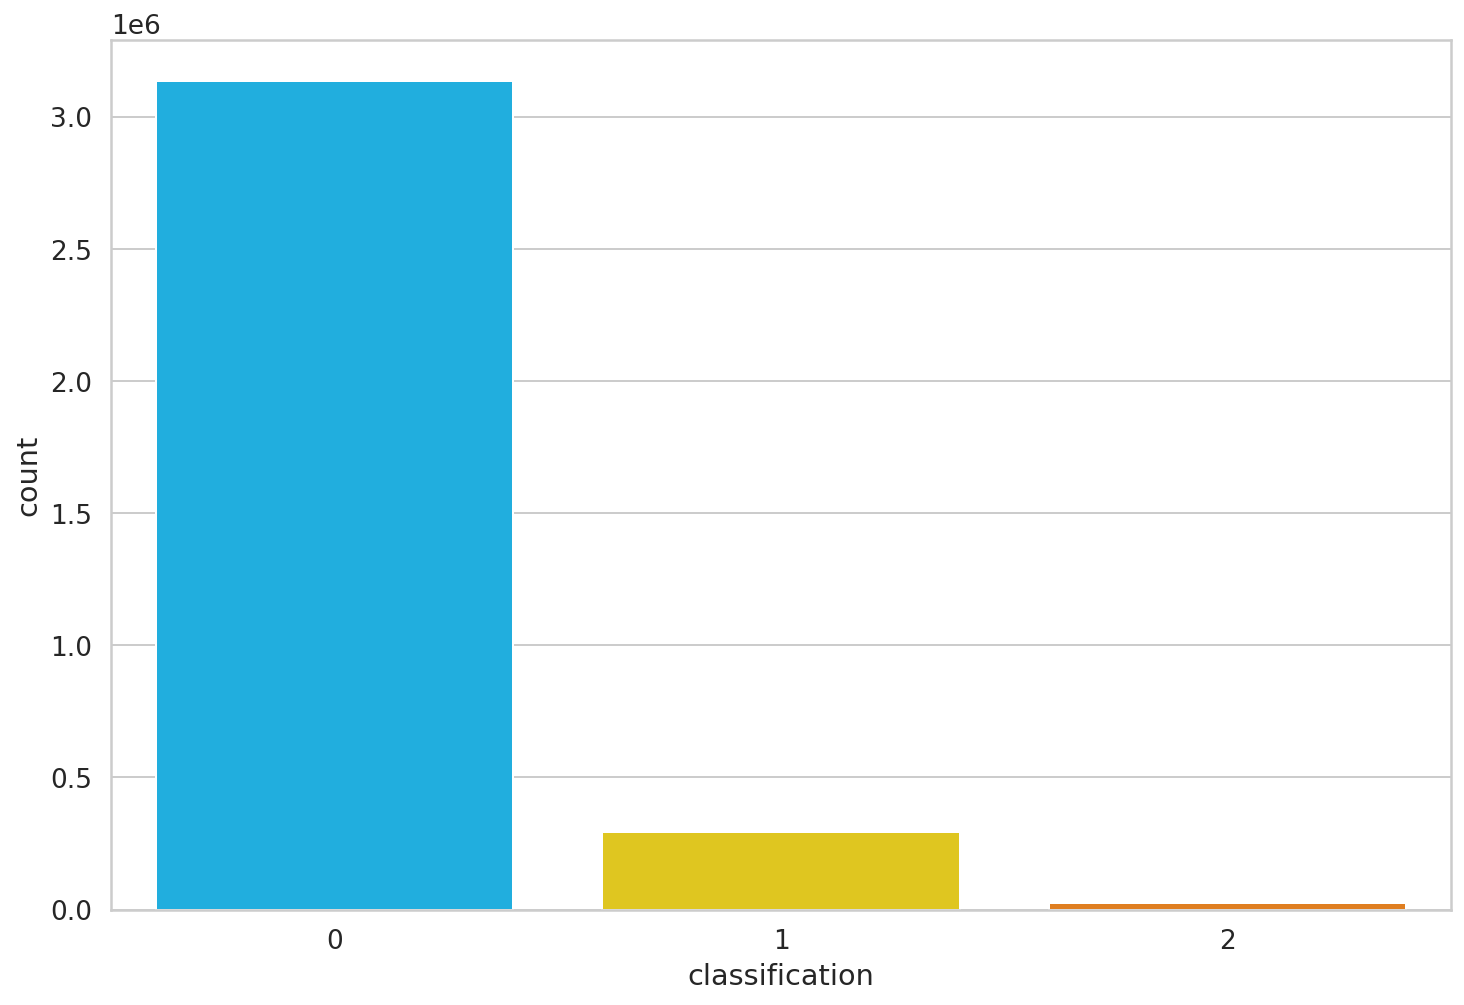

In [ ]:
sns.countplot(df.label)
plt.xlabel('classification');

In [ ]:
df.head()

,message,polarity,originalClassification,label
1,And surprise! the #RegularShow #38 has a sho...,Inconclusive,Not Classified,0
2,My unproblematic fav who knows Bellarke is f...,Inconclusive,Not Classified,0
3,I mean we know harry isn't human https//t.co...,Inconclusive,Not Classified,0
4,"She's ready, resilient, and on our latest co...",Inconclusive,Not Classified,0
5,find someone who loves you as much as Pikach...,Inconclusive,Not Classified,0


In [ ]:
df = df.drop("polarity",axis=1)
df = df.drop("originalClassification",axis=1)

In [ ]:
"""
def get_split(text):
    l_total = []
    l_parcial = []
    if len(text.split())//450 >0:
      n = len(text.split())//450
    else: 
      n = 1
    for w in range(n):
      if w == 0:
        l_parcial = text.split()[:500]
        l_total.append(" ".join(l_parcial))
      else:
        l_parcial = text.split()[w*450:w*450 + 500]
        l_total.append(" ".join(l_parcial))
    return l_total"""

'\ndef get_split(text):\n    l_total = []\n    l_parcial = []\n    if len(text.split())//450 >0:\n      n = len(text.split())//450\n    else: \n      n = 1\n    for w in range(n):\n      if w == 0:\n        l_parcial = text.split()[:500]\n        l_total.append(" ".join(l_parcial))\n      else:\n        l_parcial = text.split()[w*450:w*450 + 500]\n        l_total.append(" ".join(l_parcial))\n    return l_total'

In [ ]:
#df['message_split'] = df['message'].apply(get_split)

In [ ]:
#df['message_split']

In [ ]:
"""def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['message_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'message':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' messsage.')
    return new_df
"""


IndentationError: ignored

In [ ]:
#df = data_augumentation(df, df_name = 'all')

In [ ]:
#train_df = data_augumentation(df_train, df_name = 'training')
#val_df = data_augumentation(df_val, df_name  = 'validation')
#test_df = data_augumentation(df_test, df_name = 'testing')

In [ ]:
#df['message_len'] = df['message'].astype(str).apply(len)
#calculating the length of headlines and descriptions
#df['message_len'] = df['message'].apply(lambda x: len(str(x).split()))

In [ ]:
#df["message_len"].describe().apply(lambda x: format(x, 'f'))

In [ ]:
"""sns.displot( df , x= "message_len" );
plt.xlim([0, 50]);
"""

'sns.displot( df , x= "message_len" );\nplt.xlim([0, 50]);\n'

In [ ]:

# Class count
count_class_0, count_class_1,count_class_2 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
#df_class_3 = df[df['label'] == 3]
#df_class_4 = df[df['label'] == 4]

Random under-sampling:
2    24114
1    24114
0    24114
Name: label, dtype: int64


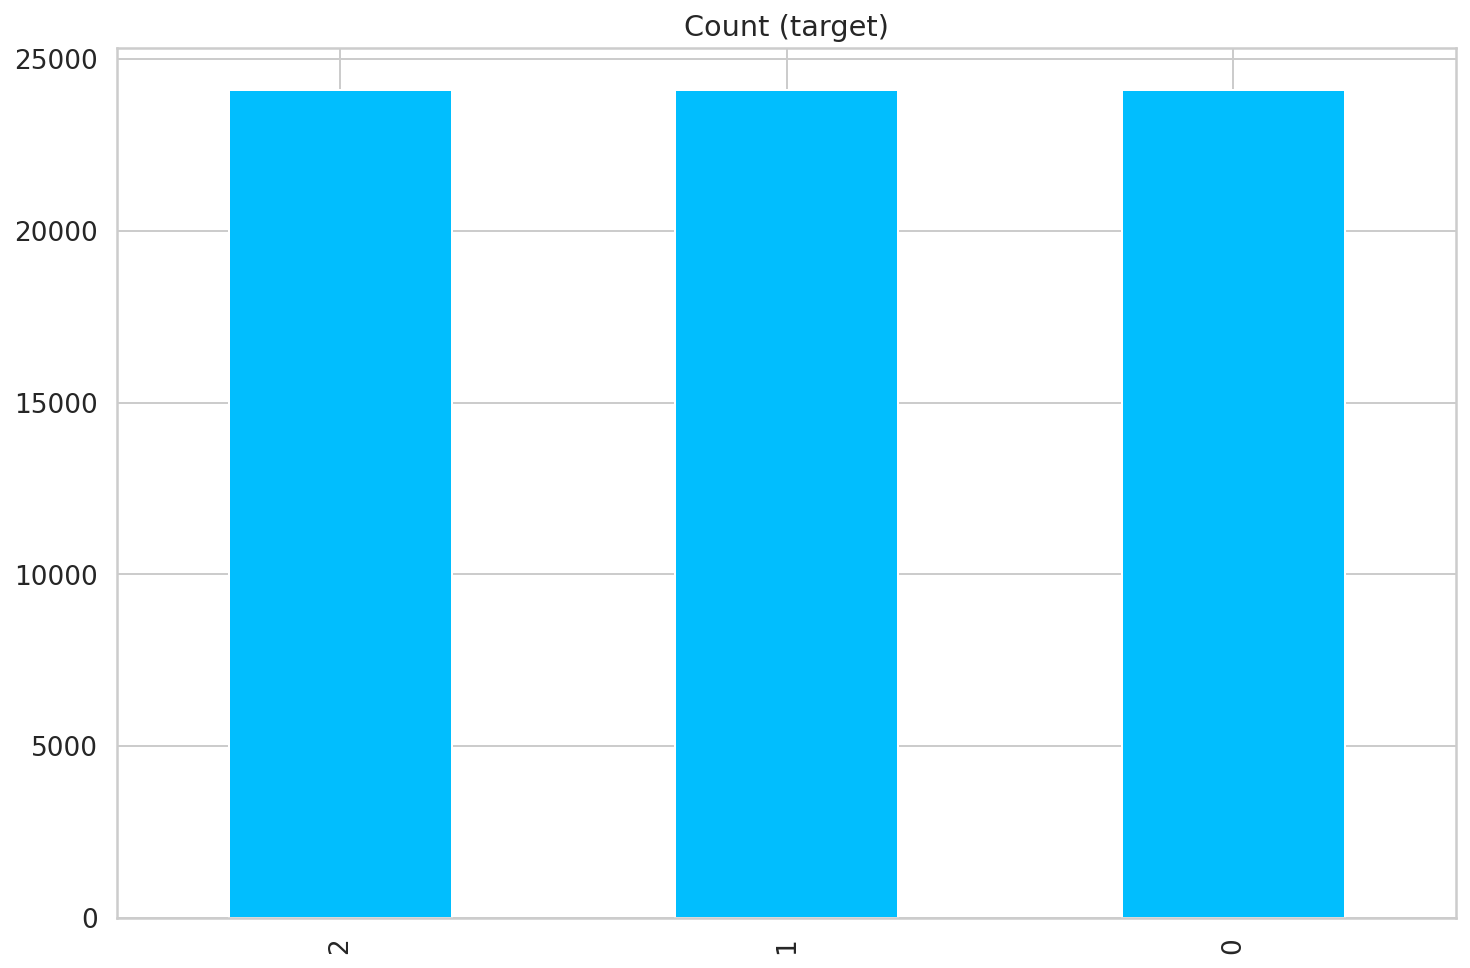

In [ ]:
df_class_0_under = df_class_0.sample(n=count_class_2,random_state = 12)
df_class_1_under = df_class_1.sample(count_class_2,random_state = 12)
#df_class_2_under = df_class_2.sample(count_class_4,random_state = 12)
#df_class_3_under = df_class_3.sample(count_class_4,random_state = 12)
df_test_under = pd.concat([df_class_0_under, df_class_1_under, df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())


df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_under.head()

,message,label
3441882,got me like https//t.co/s8hRO62rId,0
3316754,Want to look incredible? Wear the impossible P...,0
1548944,TITANBET-Get a £50 FREE bet bonus + MONEY back...,0
1285382,How to time your tweets for maximum impact htt...,0
1455758,"Come join me, or you'll be left behind #BIGOLI...",0


In [ ]:
df_test_under = df_test_under.sample(frac=1).reset_index(drop=True)

In [ ]:
df_test_under.head(10)

,message,label
0,This shit STRESSES me out. I totally lean on ...,2
1,THE WORLD OUTSIDE 1958 Sheet Music THE FOUR AC...,1
2,What type of shit is this https//t.co/2PDU4gB1E5,2
3,Please #beauty #makeup #cosmetics Even the ma...,1
4,UEM Group Charity Run @ Iskandar Puteri Canc...,1
5,I'll smack my mom to get one night with her ht...,1
6,"#NayiSoch Shocking! After Kim Kardashian, Mall...",0
7,"Art by ""my"" Evelina Larzio https//t.co/Jk7DYgrJyd",0
8,2006 FORD FOCUS 1.8TDCI Ghia BLACK DIESEL. NOT...,0
9,yomnaaaa happy birthday w 3o2bal 1000 SNA f ...,1


In [ ]:
df_train, df_test = train_test_split(
  df_test_under,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((57873, 2), (7234, 2), (7235, 2))

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
#PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
MAX_LEN = 55

In [ ]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
      
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



In [ ]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 55])
torch.Size([16, 55])


In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 55])
torch.Size([16, 55])


In [ ]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4773, 0.3475, 0.1752],
        [0.4435, 0.2816, 0.2749],
        [0.4072, 0.3437, 0.2491],
        [0.5066, 0.3076, 0.1858],
        [0.3995, 0.2875, 0.3130],
        [0.3745, 0.3836, 0.2419],
        [0.4416, 0.4191, 0.1392],
        [0.3278, 0.4523, 0.2198],
        [0.4409, 0.3018, 0.2574],
        [0.4382, 0.3465, 0.2154],
        [0.5387, 0.1938, 0.2675],
        [0.4458, 0.4120, 0.1422],
        [0.4276, 0.3032, 0.2693],
        [0.4500, 0.3373, 0.2127],
        [0.4529, 0.2612, 0.2859],
        [0.5324, 0.3996, 0.0681]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Jul 22 13:20:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    72W / 149W |   1507MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:


import torch

# Check GPU memory using nvidia-smi
#del train_data_loader
#del val_data_loader
#del test_data_loader
torch.cuda.empty_cache()
# Check GPU memory again

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 0.9 GB
Cached:    1.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [74]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 6)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 0.20780388217912912 accuracy 0.9385723912705406
Val   loss 0.10447941495775848 accuracy 0.975393972905723

Epoch 2/6
------
Train loss 0.08308144326332495 accuracy 0.9815976362034109
Val   loss 0.09121947908635503 accuracy 0.9827204865910977

Epoch 3/6
------
Train loss 0.04941908151042274 accuracy 0.9887166727143918
Val   loss 0.07924351436501034 accuracy 0.9852087365219796

Epoch 4/6
------
Train loss 0.028588105948355917 accuracy 0.9935202944378206
Val   loss 0.09028580210427069 accuracy 0.9860381531656068

Epoch 5/6
------
Train loss 0.012035885693050695 accuracy 0.997183487982306
Val   loss 0.10190407481153245 accuracy 0.9868675698092342

Epoch 6/6
------
Train loss 0.006059820225575915 accuracy 0.9986522212430666
Val   loss 0.1086906269900395 accuracy 0.9870058059165054

CPU times: user 2h 12min 5s, sys: 2min 33s, total: 2h 14min 38s
Wall time: 2h 15min 8s


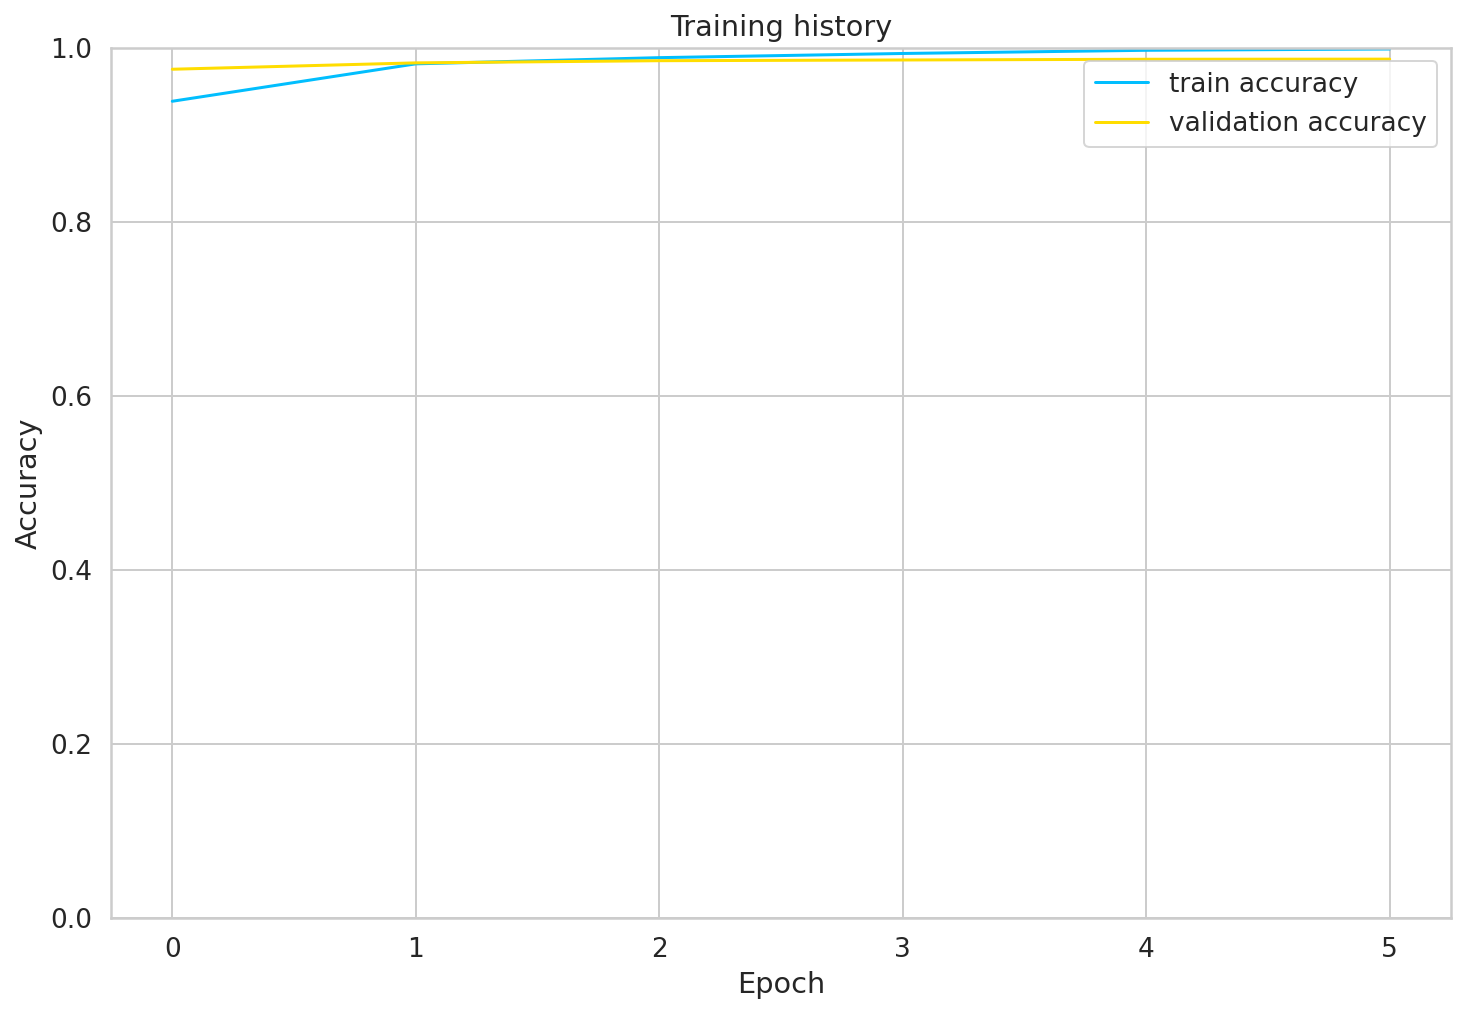

In [75]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [76]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.9865929509329648

In [77]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [78]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [79]:
print(classification_report(y_test, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

    Inconclusive       0.98      0.98      0.98      2381
Positive Extreme       0.99      0.99      0.99      2484
Negative Extreme       0.99      0.99      0.99      2370

        accuracy                           0.99      7235
       macro avg       0.99      0.99      0.99      7235
    weighted avg       0.99      0.99      0.99      7235



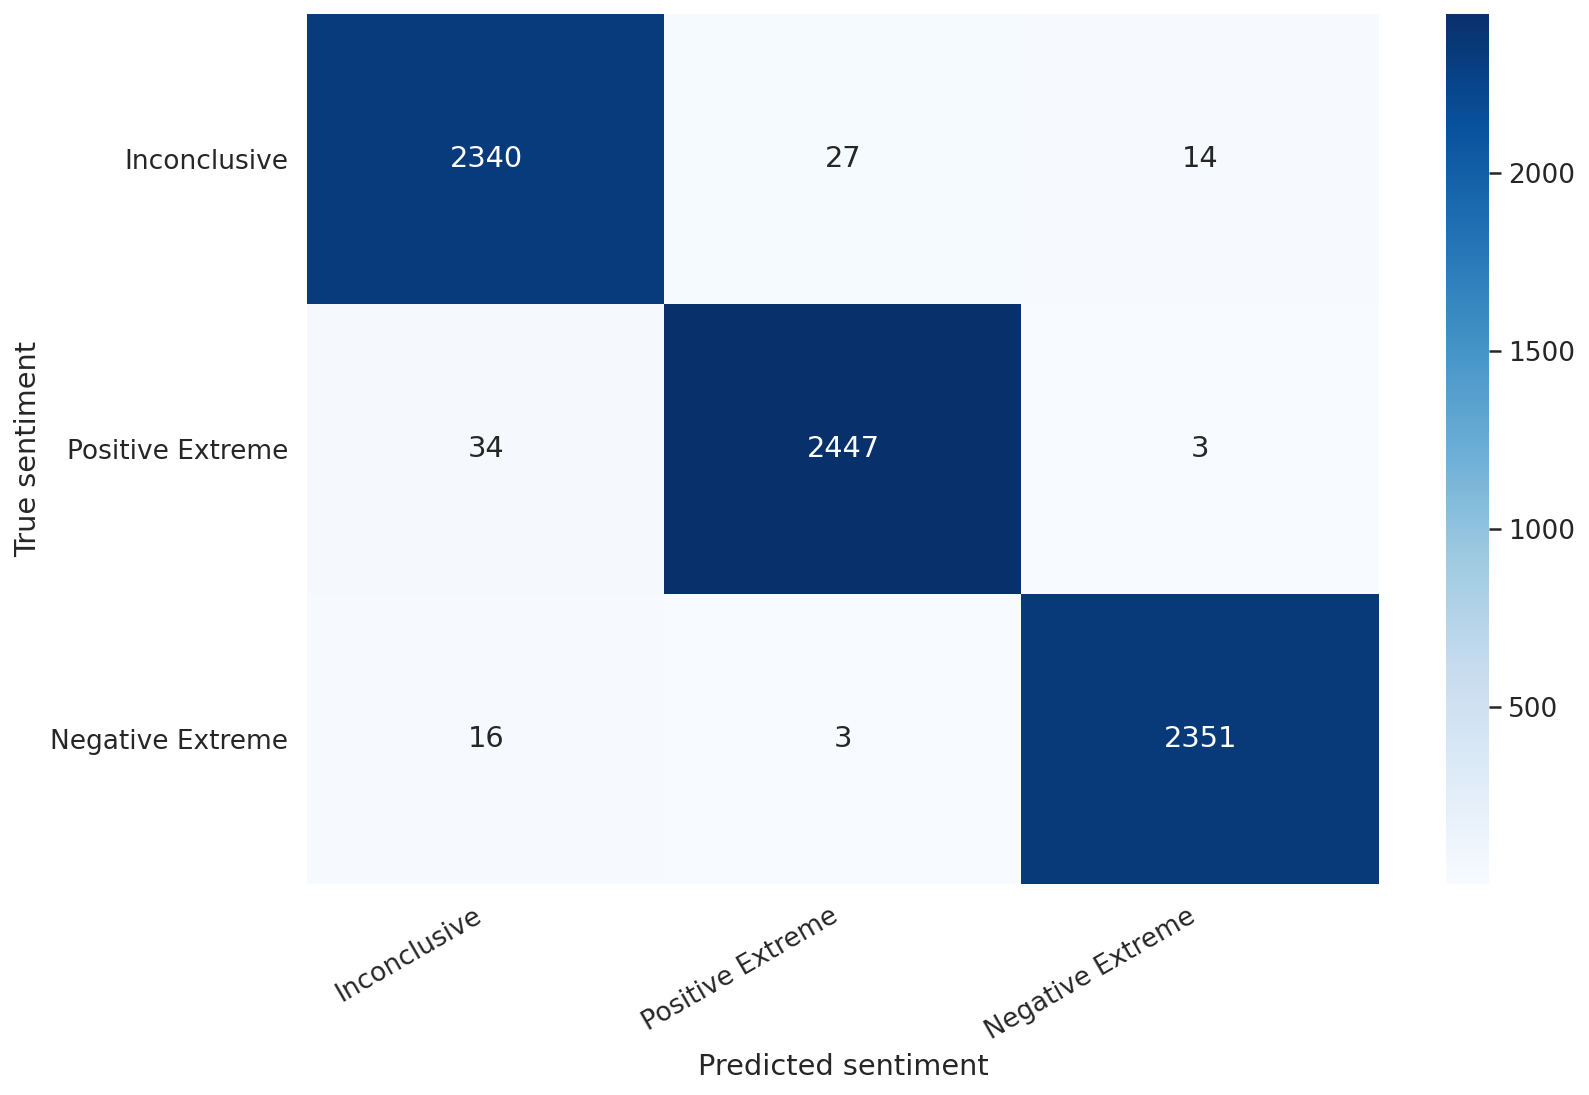

In [80]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)